# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'rennes_2019-07-25_1174226.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 2)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°2 from rennes_2019-07-25_1174226.zip: 1622005 lines
6257


,jobid,function,start,end,rank,m,n,k,duration,exp_id
0,1174226,dgemm,0.009047,0.009099,0,9726,2,2,0.000051,2
1,1174226,dgemm,0.009475,0.009548,0,9724,4,4,0.000073,2
2,1174226,dgemm,0.010086,0.010110,0,9722,2,2,0.000024,2
3,1174226,dgemm,0.010737,0.010890,0,9720,8,8,0.000153,2
4,1174226,dgemm,0.011434,0.011458,0,9718,2,2,0.000024,2


In [3]:
traces_calibration = read_csv('rennes_2019-07-26_1174295.zip', 'result.csv',)
traces_calibration = traces_calibration[traces_calibration['core'] == 0]
traces_calibration = traces_calibration.reset_index(drop=True)
print(len(traces_calibration))
traces_calibration.head()

6257


,function,m,n,k,timestamp,duration,core,jobid
0,dgemm,9726,2,2,272.521764,0.000026,0,1174295
1,dgemm,9724,4,4,272.521809,0.000071,0,1174295
2,dgemm,9722,2,2,272.521882,0.000026,0,1174295
3,dgemm,9720,8,8,272.521910,0.000143,0,1174295
4,dgemm,9718,2,2,272.522054,0.000025,0,1174295


In [4]:
sizelist_hpl = [list(t[1]) for t in traces[['m', 'n', 'k']].iterrows()]
sizelist_cal = [list(t[1]) for t in traces_calibration[['m', 'n', 'k']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [5]:
traces['duration_calibration'] = traces_calibration['duration']
traces['mnk'] = traces.m * traces.n * traces.k

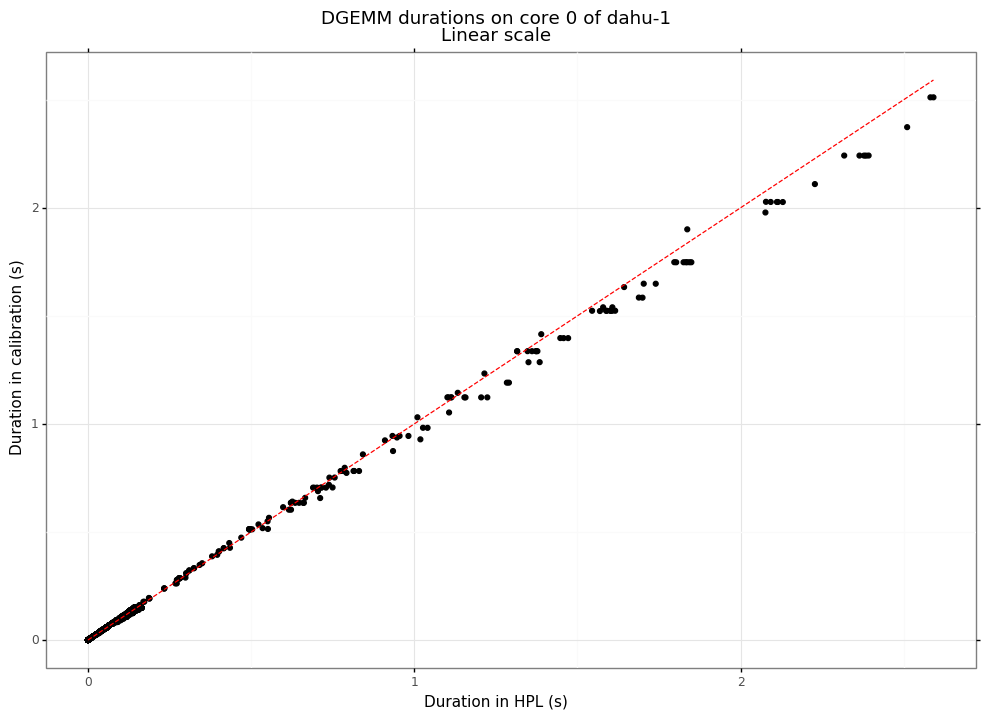

<ggplot: (-9223363271805177116)>


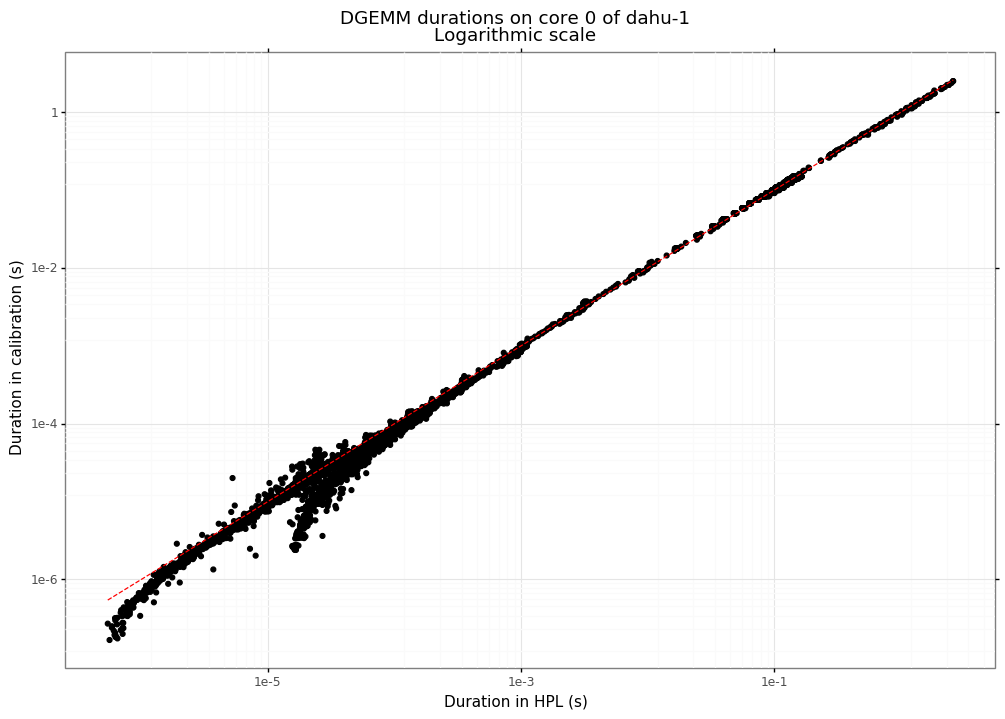

<ggplot: (8765049543944)>


In [6]:
plot = ggplot(traces, aes(x='duration', y='duration_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on core 0 of dahu-1\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [7]:
traces['gflops_hpl'] = 2*traces.mnk / traces['duration'] * 1e-9
traces['gflops_calibration'] = 2*traces.mnk / traces['duration_calibration'] * 1e-9

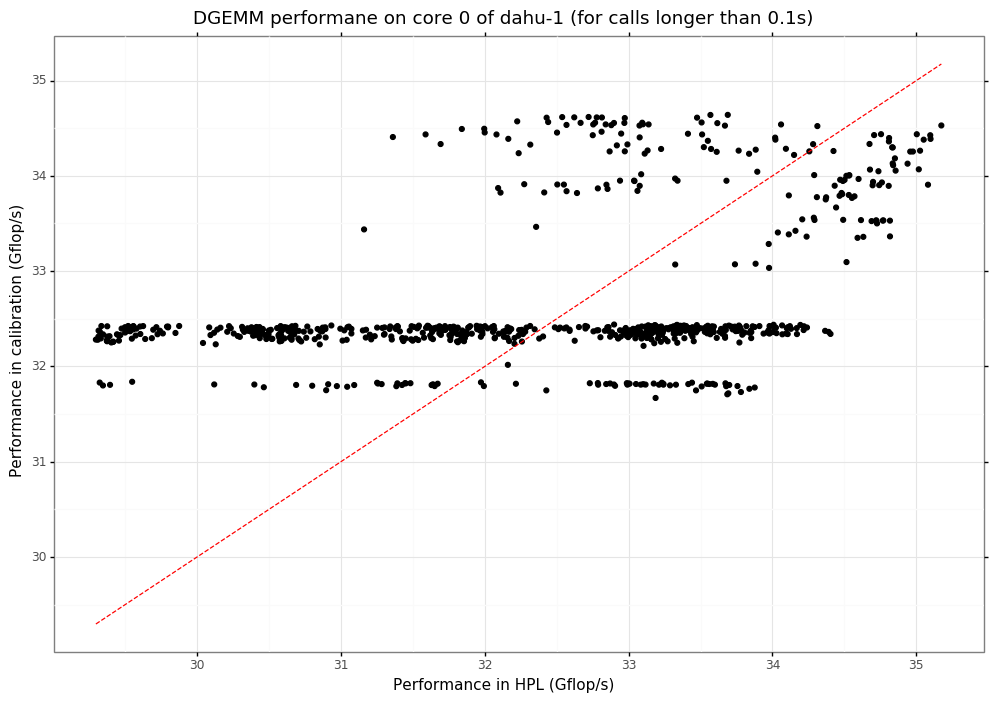

<ggplot: (8765004987382)>

In [8]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='gflops_hpl', y='gflops_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='gflops_hpl', y='gflops_hpl'), color='red', linetype='dashed')
plot = plot + xlab('Performance in HPL (Gflop/s)') + ylab('Performance in calibration (Gflop/s)')
plot + ggtitle('DGEMM performane on core 0 of dahu-1 (for calls longer than 0.1s)')

In [9]:
summary = traces[['duration', 'duration_calibration', 'mnk']].sum()
summary['gflops'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_calibration'] = 2*summary['mnk'] / summary['duration_calibration'] * 1e-9
summary['error'] = (summary['duration_calibration'] - summary['duration']) / summary['duration']
summary

duration                2.763366e+02
duration_calibration    2.724916e+02
mnk                     4.541109e+12
gflops                  3.286650e+01
gflops_calibration      3.333027e+01
error                  -1.391422e-02
dtype: float64